# Implement a support vector machine (SVM) to classify images of cats and dogs

In [1]:
#import libraries
import zipfile
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Unzip the dataset
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Paths to the zip files
train_zip_path = '/Users/souritachandra/Downloads/dogs-vs-cats/train.zip'
test_zip_path = '/Users/souritachandra/Downloads/dogs-vs-cats/test1.zip'
extract_to_train = '/Users/souritachandra/Downloads/dogs-vs-cats/train'
extract_to_test = '/Users/souritachandra/Downloads/dogs-vs-cats/test1'

unzip_file(train_zip_path, extract_to_train)
unzip_file(test_zip_path, extract_to_test)

In [3]:
# Load training data
def load_train_data(train_dir, img_size=(128, 128)):
    images = []
    labels = []
    for i in range(12500):
        cat_img_path = os.path.join(train_dir, 'cat.' + str(i) + '.jpg')
        dog_img_path = os.path.join(train_dir, 'dog.' + str(i) + '.jpg')
        cat_img = preprocess_image(cat_img_path, img_size)
        if cat_img is not None:
            features, _ = apply_hog(cat_img)
            images.append(features)
            labels.append(0)  # 0 for cat
        dog_img = preprocess_image(dog_img_path, img_size)
        if dog_img is not None:
            features, _ = apply_hog(dog_img)
            images.append(features)
            labels.append(1)  # 1 for dog
    return np.array(images), np.array(labels)


In [5]:
# Preprocess images
def preprocess_image(img_path, img_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Image at {img_path} could not be read.")
        return None
    img = cv2.resize(img, img_size)
    return img

# Apply Sobel filter
def apply_sobel(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    sobel_combined = cv2.convertScaleAbs(sobel_combined)
    return sobel_combined


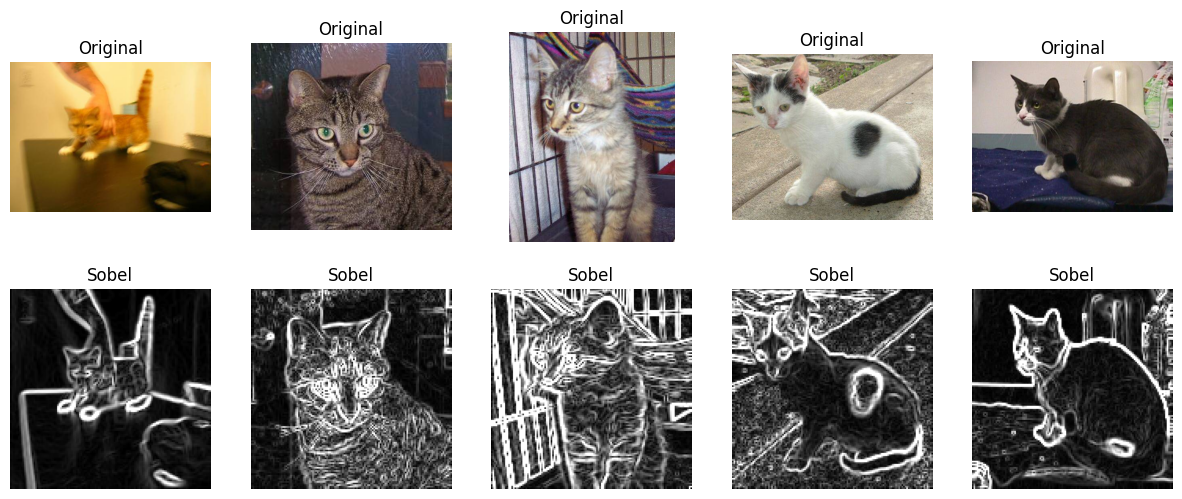

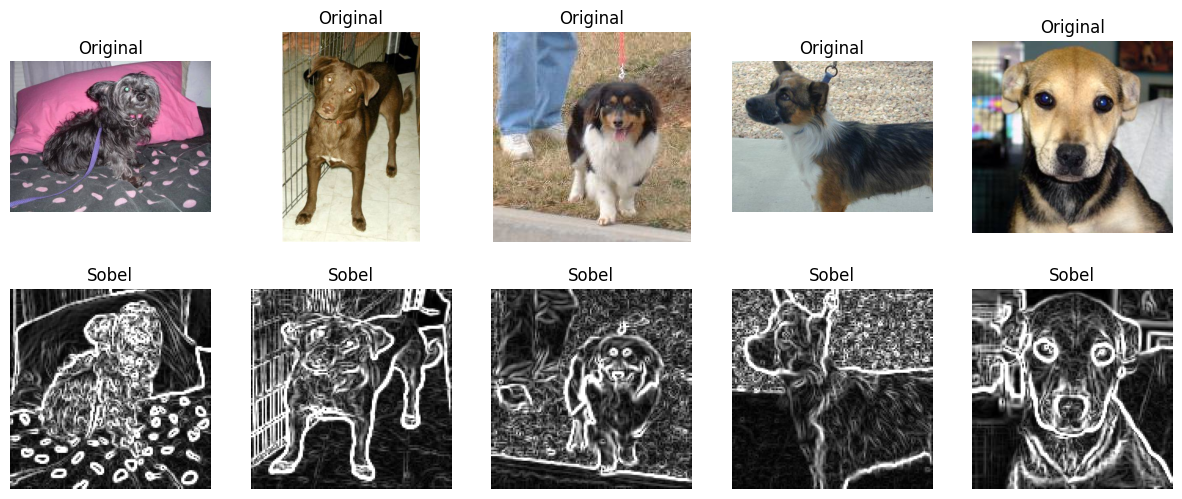

In [6]:
# Visualize some original and Sobel images
def visualize_images(image_paths, img_size=(128, 128)):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, img_path in enumerate(image_paths[:10]):
        img = preprocess_image(img_path, img_size)
        if img is not None:
            sobel_image = apply_sobel(img)
            axes[0, i % 5].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            axes[0, i % 5].set_title('Original')
            axes[0, i % 5].axis('off')
            axes[1, i % 5].imshow(sobel_image, cmap='gray')
            axes[1, i % 5].set_title('Sobel')
            axes[1, i % 5].axis('off')
        if i == 4:
            plt.show()
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    plt.show()

# Paths to sample images
extract_to_train = '/Users/souritachandra/Downloads/dogs-vs-cats/train'
sample_image_paths = [os.path.join(extract_to_train, f'cat.{i}.jpg') for i in range(5)] + \
                     [os.path.join(extract_to_train, f'dog.{i}.jpg') for i in range(5)]

# Visualize the images
visualize_images(sample_image_paths)

In [7]:
# Load test data
def load_test_data(test_dir, img_size=(128, 128)):
    images = []
    image_ids = []
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        img = preprocess_image(img_path, img_size)
        if img is not None:
            features, _ = apply_hog(img)
            images.append(features)
            image_ids.append(int(img_file.split('.')[0]))
    return np.array(images), image_ids

In [9]:
# Apply HOG
def apply_hog(img):
    features, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')
    return features, hog_image

In [10]:
# Load the training data
train_images, train_labels = load_train_data(extract_to_train)
print("Training data loaded.")

Training data loaded.


In [11]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
print("Training and validation data split.")

Training and validation data split.


In [12]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("Data normalized.")

Data normalized.


In [13]:
# Apply PCA to reduce the dimensionality
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
print("PCA applied.")

PCA applied.


In [14]:
# Parameter tuning using GridSearchCV with SGDClassifier
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
grid_search = GridSearchCV(SGDClassifier(loss='hinge', max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'alpha': 0.1}


In [15]:
# Train the SGDClassifier model with the best parameters
sgd_model = SGDClassifier(loss='hinge', alpha=grid_search.best_params_['alpha'], max_iter=1000)
sgd_model.fit(X_train_pca, y_train)
print("Model trained with best parameters.")

Model trained with best parameters.


In [16]:
# Predict on the validation set
val_predictions = sgd_model.predict(X_val_pca)

In [17]:
# Calculate and print the accuracy
accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 70.00%


In [19]:
# Predict on the test data
test_images, test_ids = load_test_data(extract_to_test)
test_images_scaled = scaler.transform(test_images)
test_images_pca = pca.transform(test_images_scaled)
print("Test data loaded.")
test_predictions = sgd_model.predict(test_images_pca)

Test data loaded.


In [20]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id': test_ids, 'label': test_predictions})
submission_df.to_csv('sampleSubmission.csv', index=False)
print("Submission file saved.")

Submission file saved.
